![](../images/Title_ex_6.2.4.png)

# 1. Introduction

In this notebook we will explore some other drought indices and platforms on where to retrieve relevant information. First we will have a look at the Standardized Precipitation-Evapotranspiration Index (SPEI). This index is based on a standardized anomaly of precipitation and evapotranspiration varying with different timescales (averaged over 1 month: spei01, averaged over 3 months: spei03 and so on). The data at a resolution of 1°x1° can be viewed and downloaded [here](https://spei.csic.es/map/maps.html#months=1#month=5#year=2022) this dataset is available up till now. The higher resolution dataset of 0.5°x0.5° runs until december 2020 and can be viewed and downloaded [here](https://spei.csic.es/spei_database/#map_name=spei03#map_position=1439).

Both datasets have been downloaded for you and are available in the /data folder of this exercise.


Something about LST and ERA5 data? 

# 2. Libraries

In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import rioxarray
import cftime
import xarray
import glob
from pathlib import Path
import numpy as np

To run this notebook you need to install the **cftime** and **nc-time-axis** python packages.

# 3. SPEI

The datasets can be downloaded as a NetCDF file (.nc). We can open such files with different packages like NetCDF4, rioxarray, gdal... In this notebook we will show how to retrieve the data and plot timeseries using the rioxarray package. 

## 3.1 Reading NetCDF files

In [17]:
# Reading the one degree dataset...
fn = './data/spei03_one_degree.nc' 
spei_ds = rioxarray.open_rasterio(fn)
# # to shorten the list and delete recurring units
spei_ds.attrs['units'] = 'Standardized values' 
spei_ds

<xarray.DataArray 'spei' (time: 871, y: 180, x: 360)>
[56440800 values with dtype=float32]
Coordinates:
  * time         (time) object 1950-01-01 00:00:00 ... 2022-07-01 00:00:00
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 176.5 177.5 178.5 179.5
    spatial_ref  int64 0
Attributes:
    long_name:     standardized precipitation-evapotranspiration index
    units:         Standardized values
    _FillValue:    -1.0000000200408773e+20
    scale_factor:  1.0
    add_offset:    0.0

As you can see in the coordinates of this layer stack, the time represents each month from the first of January 1950 up until the first of July 2022. The x coordinate represents the longitude of the center of the pixel, whereas the y coordinate represents the central latitude of the pixel. Keep in mind that the coordinate spei_ds[0, 0, 0] represents the SPEI value from the pixel with central WGS84 cooordinates 179.5 E and 89.5 N at the Januari first 1950. Therefore, we should be careful when selecting the right coordinates.

In [18]:
# read the 0.5 degree resolution dataset...
fn = './data/spei03_half_degree.nc' 
spei_ds2 = rioxarray.open_rasterio(fn)
spei_ds2.attrs['units'] = 'z-values' 
spei_ds2

<xarray.DataArray 'spei' (time: 1440, y: 360, x: 720)>
[373248000 values with dtype=float32]
Coordinates:
  * time         (time) object 1901-01-16 00:00:00 ... 2020-12-16 00:00:00
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
Attributes:
    long_name:     Standardized Precipitation-Evapotranspiration Index
    units:         z-values
    _FillValue:    1.0000000150474662e+30
    scale_factor:  1.0
    add_offset:    0.0

Note that the spatial coordinates in this dataset are defined differently compared to the 1° version!

## 3.2 Plot SPEI area for a specific date

The date in this NetCDF files is stored as a cftime.DatetimeProlepticGregorian type. In order to call the right month we need to take this into account. 

Let's say you want to retrieve the SPEI map for August in 2015 for the continent of Africa. You can enter the following query.

Note: to get a latitude from 40 N to 38 S we need to subtract and add these values from 90 because the equator has pixelnumber 90. Same logic applies to the longitude.

In [19]:
array = spei_ds[spei_ds.time == cftime.DatetimeProlepticGregorian(2015, 8, 1), # coordinate 1: timeperiod in proleptic gregorian
                (90-40):(90+38), # latitude accounting for the pixel numbering in the array 
                (180-25):(180+55)] # longitude accounting for the pixel numbering in the array 

In order to get nice maps, we need to mask out the pixels with the "FillValue"

In [20]:
array_mask = array.where(array != array._FillValue)

Now we can plot the SPEI map:

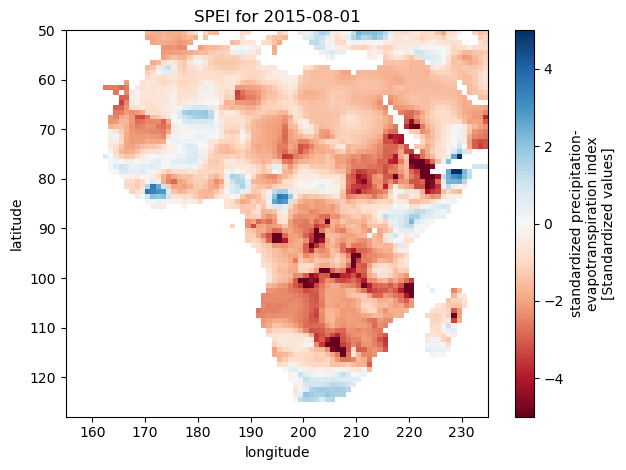

In [21]:
array_mask.plot(cmap="RdBu")
plt.title("SPEI for 2015-08-01")
plt.ylabel("latitude")
plt.xlabel("longitude")
# we need to invert the latitude axis in order to correctly visualize the result
plt.gca().invert_yaxis()
plt.tight_layout()
plt.draw()

## 3.3 Plot timeseries for a specific point

When interested in the SPEI values of a specific pixel over a long period of time, the query can be altered:

In [22]:
array_pt = spei_ds[(spei_ds.time >= cftime.DatetimeProlepticGregorian(2010, 1, 1)) & 
                 (spei_ds.time <= cftime.DatetimeProlepticGregorian(2020, 12, 1)),  # coordinate 1: timeperiod in proleptic gregorian
                 (90+4), # latitude accounting for the pixel numbering in the array 
                 (180+23)] # longitude accounting for the pixel numbering in the array 

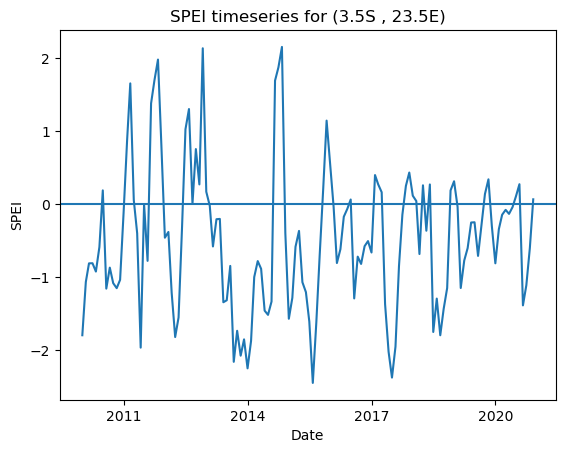

In [23]:
array_pt.plot()
plt.title("SPEI timeseries for (3.5S , 23.5E)")
plt.xlabel('Date')
plt.ylabel('SPEI')
plt.axhline(y=0)

Inspect the plot above and reflect on the meaning of the SPEI indicator. What does a positive and negative value imply?

# 4. Land surface temperature - air temperature

In exercise 6.2.2 we downloaded some land surface temperature data from the MODIS sensor. 

When combining this information with ambient air temperature(Ta), we end up with a generic indicator on drought stress:

LST - Ta

For well-watered, healthy vegetation, this difference should be relatively small. As drought stress increases, plants will close their stomata, thereby stopping transpiration. As a side effect, the plants start to heat up, meaning the difference between LST and Ta will increase with increasing degrees of drought stress.

Air temperature data can be downloaded from the Copernicus Climate data store.
For instance, the [AgERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=overview) provides climate data specifically suited for agricultural applications at a 10 km spatial and daily temporal resolution.

Through the CDS website, you can download these data for a specific time period and area of interest of your own choice -> https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=form

We have downloaded data for the year 2020 and for the following bounding box (containing the point of interest for which we downloaded LST data in the exercise on LST timeseries):
12° N - 9° N
38° E - 42° E

The data can be found in the /data/agera5 folder.

Let's extract the timeseries for our point of interest (10.69° N; 40.766° E) from these files...

In [10]:
def extract_agera5_timeseries(indir, variable, start_date, end_date, lat, lon):
    '''
    Extract timeseries for a point from a series of files
    as downloaded from the Copernicus Climate Data Store.
    
    - indir = directory containing downloaded files (posixPath object)
    - variable = name of variable of interest,
        should match description in filenames!
    - start_date in format %Y-%m-%d.
    - end_date in format %Y-%m-%d.
    - lat - latitude of point of interest
    - lon - longitude of point of interest
    
    '''
    # create date range
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # create output
    df = pd.DataFrame(columns=[variable], index=date_range)
    
    # loop over all dates and extract value for each date
    for date in date_range:
        date_str = date.strftime(format='%Y%m%d')
        infile = glob.glob(str(indir / f'*{variable}*_AgERA5_{date_str}_*.nc'))
        if len(infile) == 0:
            raise FileNotFoundError(f'File for date {date_str} not found!')
        else:
            infile = infile[0]
        data = rioxarray.open_rasterio(infile)
        value = data.sel(dict(x=lon, y=lat), method='nearest')
        df.loc[date] = value
    
    return df

In [11]:
# specify time period
start_date = '2020-01-01'
end_date = '2020-12-31'

# specify variable we're interested in
# (should match what is present in the downloaded filenames)
variable = 'Temperature-Air-2m-Mean-24h'

# specify location
lon = 40.766
lat = 10.69

# specify folder containing the data
agera5_folder = Path('./data/agera5')

ta = extract_agera5_timeseries(agera5_folder, variable, start_date, end_date, lat, lon)  
ta.head()


,Temperature-Air-2m-Mean-24h
2020-01-01,298.690613
2020-01-02,299.602142
2020-01-03,299.594269
2020-01-04,299.044098
2020-01-05,298.766663


Now load again the LST data and visualize the difference between the two metrics.

<AxesSubplot:>

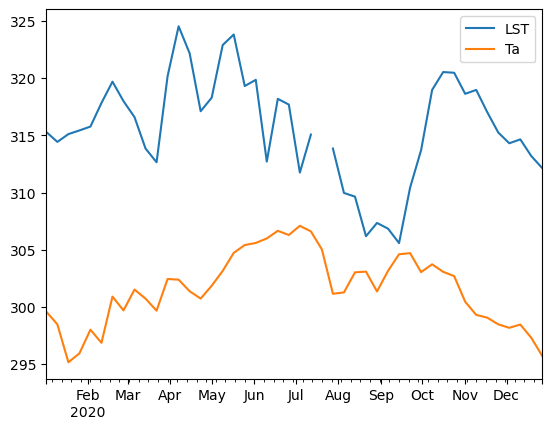

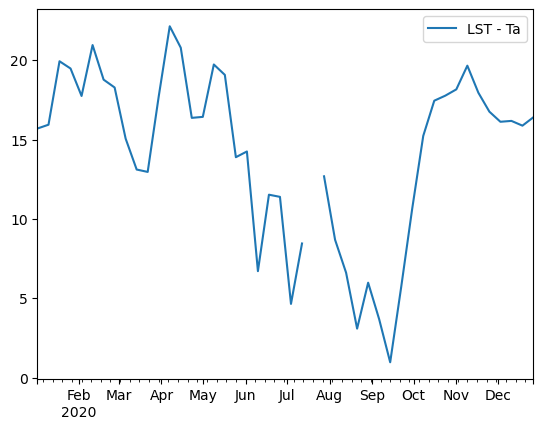

In [24]:
infile = './data/lst_timeseries.csv'
lst = pd.read_csv(infile, parse_dates=['date'], index_col=['date'])

# subset data based on start and end date defined earlier
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
lst = lst.loc[(lst.index >= start_date) & (lst.index <= end_date)]

# merge the two variables in one dataframe
data = pd.merge(ta, lst, right_index=True, left_index=True)

# rename temperature column
data = data.rename(columns={variable: 'Ta'})

# compute difference
data['LST - Ta'] = data['LST'] - data['Ta']

# plot LST and Ta separately
fig, ax = plt.subplots()
data[['LST', 'Ta']].plot(ax=ax)

# plot the difference
fig, ax = plt.subplots()
data[['LST - Ta']].plot(ax=ax)


Our point of interest is located in the Yangudi Rassa National Park in Ethiopia and is mostly covered by sparse shrubland.

Based on the graphs produced before, when is the main vegetation season taking place?

Quickly check your findings with the crop calendar of Ethiopia, available at:

https://ipad.fas.usda.gov/rssiws/al/crop_calendar/eafrica.aspx